In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# Імпорт даних

In [2]:
orders = pd.read_csv('orders.csv')

In [3]:
nodes = pd.read_csv('nodes.csv')

In [4]:
orders.head()

,Id,running_time,completed_time,route_distance_km,delta_time
0,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.740,862.0
1,-7575630690398473489,2022-01-24 06:53:53,2022-01-24 07:06:26,3.526,753.0
2,-6264582368520213833,2022-01-24 10:00:59,2022-01-24 10:15:58,5.071,899.0
3,5964315354301636538,2022-01-24 14:28:05,2022-01-24 14:35:08,2.867,423.0
4,1372379574816145639,2022-01-24 11:57:29,2022-01-24 12:06:29,3.751,540.0


In [5]:
nodes.head()

,Id,node_start,node_finish,distance,speed
0,-2627062893189810184,10980432,2133368107,17.414917,32.0
1,-2627062893189810184,10980433,5212387954,17.186539,26.0
2,-2627062893189810184,10980445,5221700954,28.513481,26.0
3,-2627062893189810184,10980498,10980445,154.266122,25.0
4,-2627062893189810184,10980647,1986137911,8.542824,29.0


In [6]:
print(f'orders shape -> {orders.shape}\nnodes shape -> {nodes.shape}')

orders shape -> (5000, 5)
nodes shape -> (480291, 5)


In [7]:
df = pd.merge(orders, nodes)

In [8]:
df.head()

,Id,running_time,completed_time,route_distance_km,delta_time,node_start,node_finish,distance,speed
0,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.74,862.0,10980417,4768348185,31.771489,30.0
1,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.74,862.0,10980418,1570776947,3.673054,24.0
2,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.74,862.0,10980430,4768348188,15.550612,27.0
3,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.74,862.0,10980431,5125489557,50.034390,29.0
4,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.74,862.0,10980432,5213300015,13.453126,30.0


#### Перевіримо на пропуски

In [9]:
df.isnull().sum()

Id                      0
running_time            0
completed_time          0
route_distance_km       0
delta_time              0
node_start              0
node_finish             0
distance                0
speed                3268
dtype: int64

In [10]:
df = df.dropna()

#### Зробимо декілька графіків, щоб побачить викиди

Text(0.5, 1.0, 'Відстань маршруту до фільтрації')

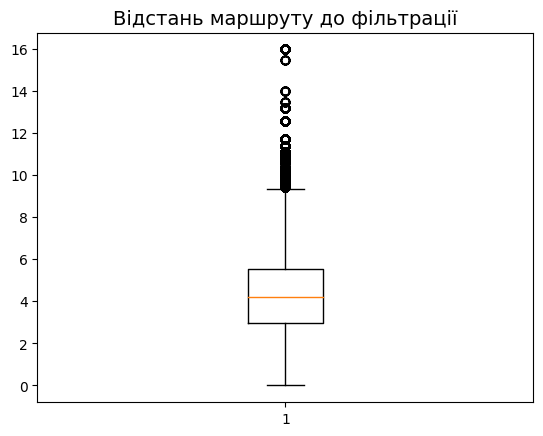

In [11]:
plt.boxplot(df.route_distance_km)
plt.title('Відстань маршруту до фільтрації', fontsize=14)

{'whiskers': [<matplotlib.lines.Line2D at 0x16265ce50>,
 'caps': [<matplotlib.lines.Line2D at 0x16265d390>,
 'boxes': [<matplotlib.lines.Line2D at 0x16265cbb0>],
 'medians': [<matplotlib.lines.Line2D at 0x16265d8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x16265db70>],
 'means': []}

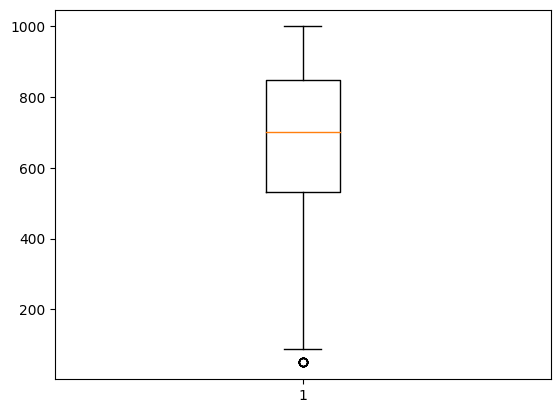

In [12]:
plt.boxplot(df.delta_time)

#### Це дивно, коли люди замовляють таксі, щоб проїхати 100-400 метрів, тому врахуємо це як викид

In [13]:
(df.route_distance_km < 0.5).sum()

339

In [14]:
df = df[df.route_distance_km > 0.5]

#### Спробуємо знайти викиди через describe

In [15]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,Id,route_distance_km,delta_time,node_start,node_finish,distance,speed
count,397704.00000,397704.00000,397704.00000,397704.00000,397704.00000,397704.00000,397704.00000
mean,126719889555509808.00000,4.38355,681.92744,3827018244.53104,3827118466.98824,38.06651,31.32537
std,5353461444018895872.00000,1.87684,199.88600,2706566253.35328,2707037722.99388,43.69152,10.15407
min,-9220688251826578432.00000,0.53900,87.00000,10980417.00000,10980417.00000,0.07658,5.00000
25%,-4429438430273948672.00000,2.96200,532.00000,1570777036.00000,1570777036.00000,9.58600,24.00000
50%,108916519737659120.00000,4.18600,700.00000,4427597533.00000,4427569174.00000,22.37987,30.00000
75%,4838860647517621248.00000,5.53200,848.00000,5214944836.00000,5214944843.00000,50.25324,37.00000
max,9222286614781517824.00000,15.95400,999.00000,8952486639.00000,8952486639.00000,1374.51087,100.00000


In [16]:
df.dtypes

Id                     int64
running_time          object
completed_time        object
route_distance_km    float64
delta_time           float64
node_start             int64
node_finish            int64
distance             float64
speed                float64
dtype: object

#### Для зручності залишимо дату та годину, бо інформація про хвилини нам нічого не дасть

In [17]:
df.running_time = df.running_time.astype("datetime64[ns]").dt.to_period("H")
df.completed_time = df.completed_time.astype("datetime64[ns]").dt.to_period("H")

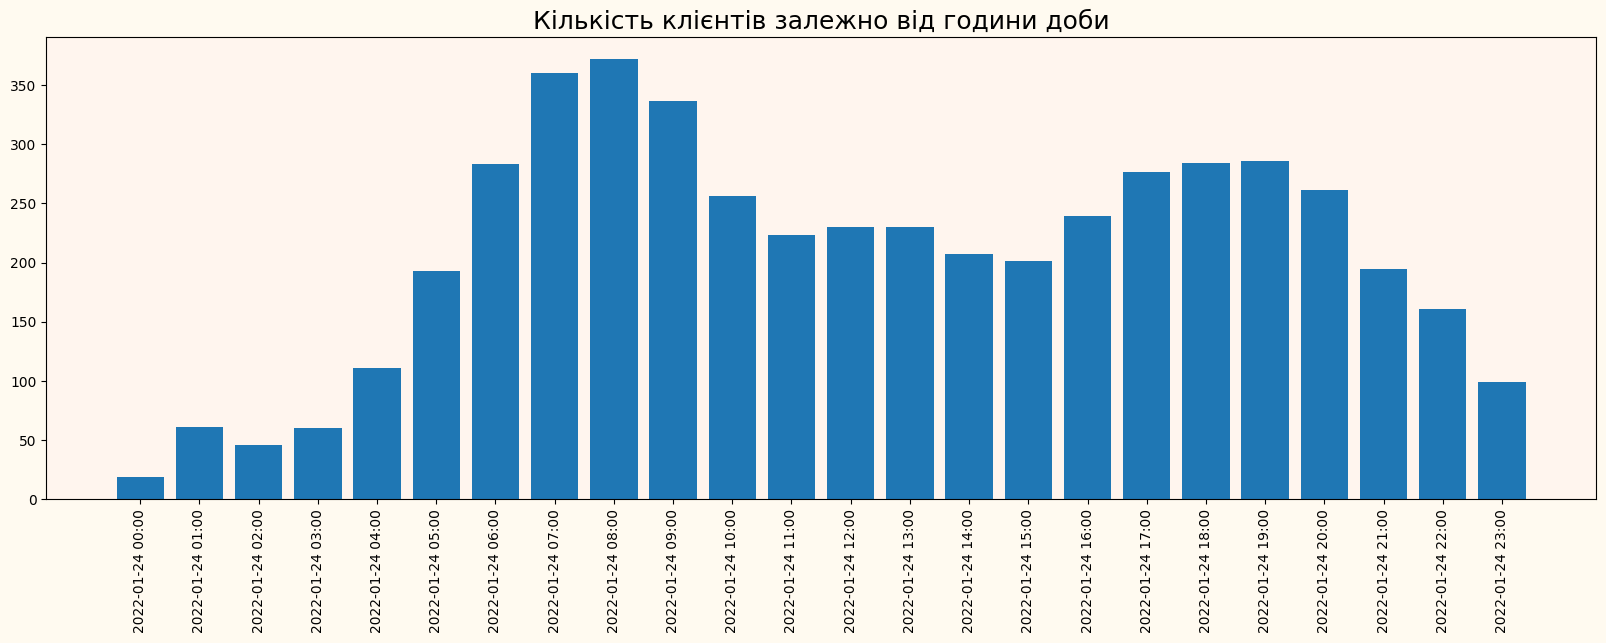

In [18]:
df_g = df.drop_duplicates('Id')
df_g = df_g.groupby('running_time').agg({'Id': 'count'}).reset_index()\
    .rename(columns={'Id': 'Amount'})

x = np.array(df_g.running_time.astype(str))
y1 = np.array(df_g.Amount)

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.xticks(rotation=90)
plt.title('Кількість клієнтів залежно від години доби', fontsize=18)

plt.show()

#### Діапазон по даті це 1 день, тому візьмемо інформацію про погоду погодинно на цей день

In [19]:
weather = pd.read_csv('https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/retrievebulkdataset?&key=B2JPHZFZ2VPKMQHA275NRFBZZ&taskId=5468aa32f44a6aa301b1fcf6c95ebdc4&zip=false')

In [20]:
weather.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,Одеса,2022-01-24T00:00:00,-4.00000,-11.10000,-5.00000,92.75000,0,0,NaN,0.00000,0.00000,36.70000,25.20000,20,1024.00000,50.00000,10.00000,0.00000,NaN,0.00000,10,Partially cloudy,partly-cloudy-night,"UKOO,33837099999"
1,Одеса,2022-01-24T01:00:00,-4.00000,-10.50000,-6.00000,85.97000,0,0,NaN,0.00000,0.00000,38.20000,21.60000,10,1024.00000,64.60000,10.00000,0.00000,NaN,0.00000,10,Partially cloudy,partly-cloudy-night,"UKOO,33837099999"
2,Одеса,2022-01-24T02:00:00,-4.00000,-11.50000,-6.00000,85.97000,0,0,NaN,0.00000,0.00000,41.40000,28.80000,360,1025.00000,89.10000,5.00000,NaN,NaN,NaN,10,Partially cloudy,partly-cloudy-night,"UKOO,33837099999"
3,Одеса,2022-01-24T03:00:00,-4.00000,-11.50000,-5.00000,92.75000,0,0,NaN,0.00000,0.00000,41.00000,28.80000,360,1025.00000,89.10000,6.00000,0.00000,NaN,0.00000,10,Partially cloudy,partly-cloudy-night,"UKOO,33837099999"
4,Одеса,2022-01-24T04:00:00,-4.00000,-11.50000,-5.00000,92.75000,0,0,NaN,0.00000,0.00000,42.80000,28.80000,360,1025.00000,89.10000,7.00000,0.00000,NaN,0.00000,10,Partially cloudy,partly-cloudy-night,"UKOO,33837099999"


#### Відберемо тільки ті метрики, які нас цікавлять

In [21]:
weather = weather[['datetime', 'temp', 'precip', 'snow', 'snowdepth']]

In [22]:
weather.datetime = weather.datetime.astype("datetime64[ns]").dt.to_period("H")

In [23]:
weather.temp = weather.temp.astype(int)
weather.snow = weather.snow.astype(int)
weather.snowdepth = weather.snowdepth.astype(int)
weather = weather.rename(columns={'datetime': 'running_time'})

In [24]:
weather.head()

,running_time,temp,precip,snow,snowdepth
0,2022-01-24 00:00,-4,0,0,0
1,2022-01-24 01:00,-4,0,0,0
2,2022-01-24 02:00,-4,0,0,0
3,2022-01-24 03:00,-4,0,0,0
4,2022-01-24 04:00,-4,0,0,0


In [25]:
df = pd.merge(df, weather)

#### Для подальших маніпуляцій з даними, створимо ще колонку з годинами

In [26]:
df['running_hour'] = df['running_time'].apply(lambda x: x.hour)

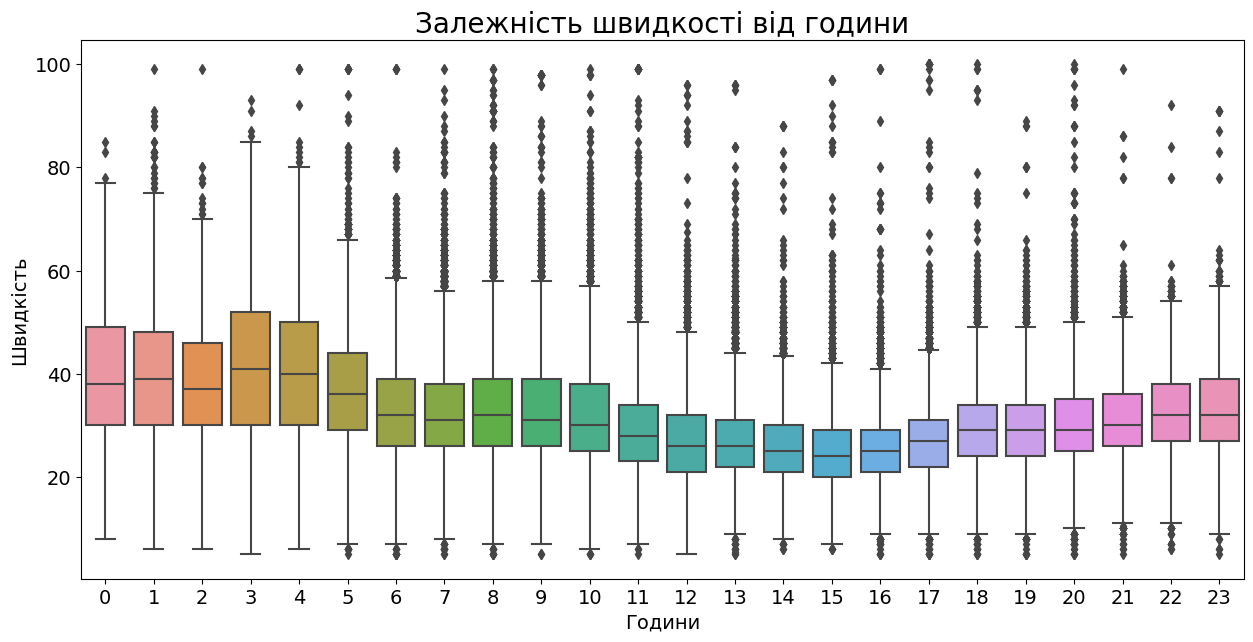

In [27]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='running_hour', y='speed', data=df)

plt.title('Залежність швидкості від години', fontsize=20)
plt.ylabel('Швидкість', fontsize=14)
plt.xlabel('Години', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

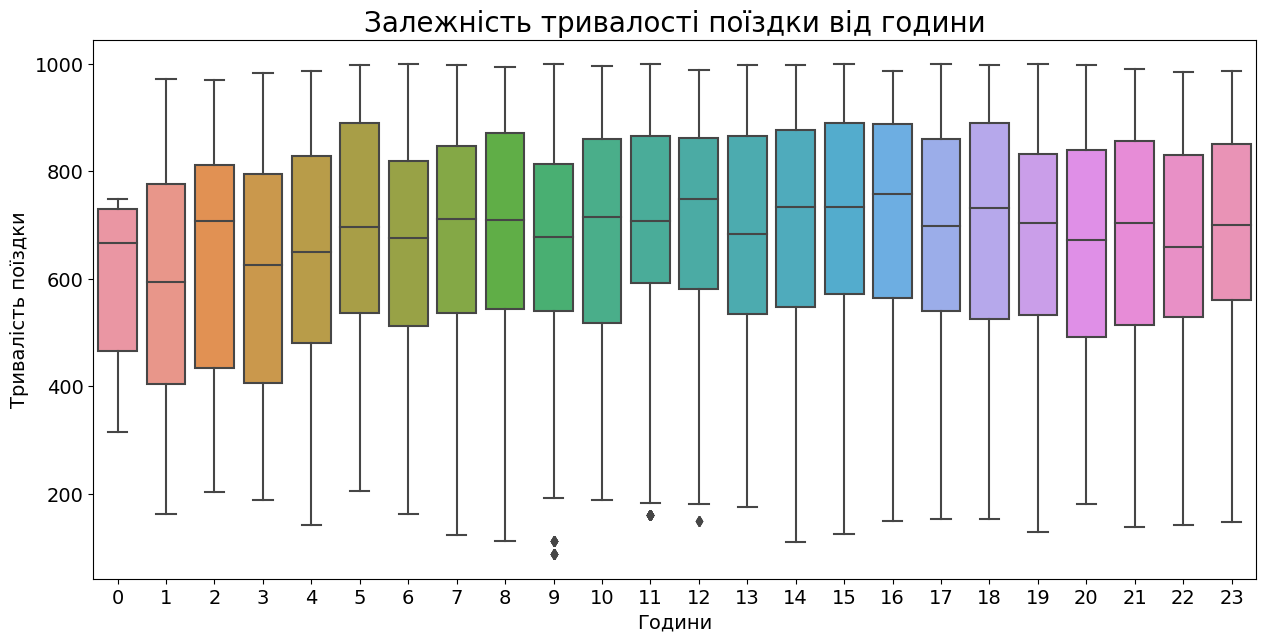

In [28]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='running_hour', y='delta_time', data=df)

plt.title('Залежність тривалості поїздки від години', fontsize=20)
plt.ylabel('Тривалість поїздки', fontsize=14)
plt.xlabel('Години', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### Подивимося які значення добре корелюють, щоб потім їх взяти для моделі

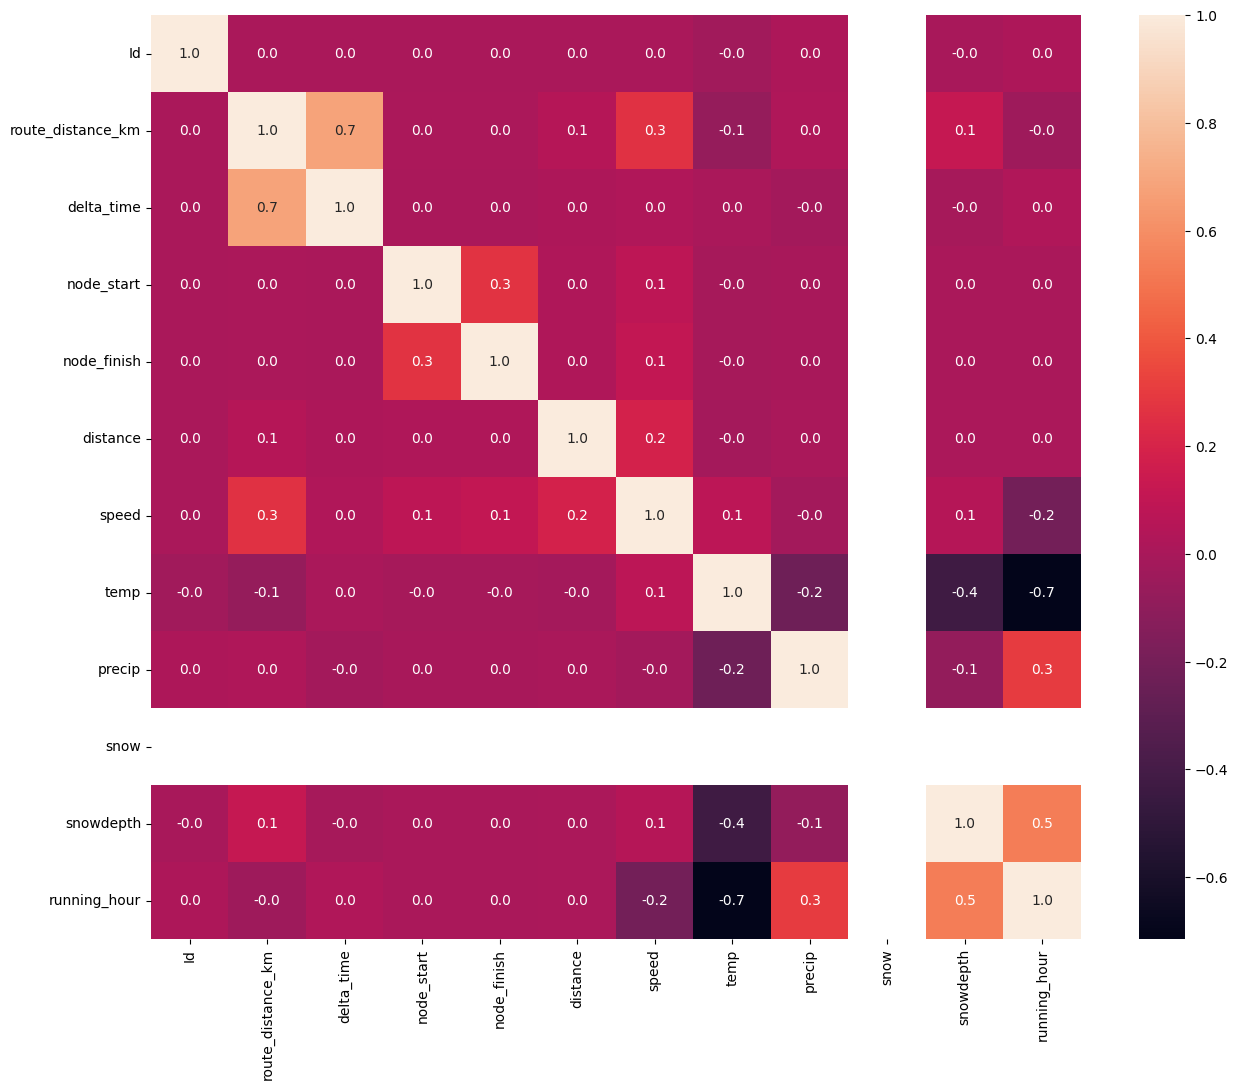

In [29]:
plt.figure(figsize=(15, 12))

sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".1f");

# Створення моделі

#### Відберемо метрики, які добре корелюють між собою та часом

In [30]:
X = df[['route_distance_km','temp', 'precip', 'snow', 'snowdepth', 'speed']]
y = df['delta_time']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Поексперементуємо з різними моделями

In [32]:
models = [LinearRegression(), Ridge(), DecisionTreeRegressor(),
          RandomForestRegressor(), Lasso()]
rows = []
for clf in models:
    clf.fit(X_train, y_train) 
    print(f'\n {clf}')
    time = %time clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)    
    rows.append([clf, round(np.sqrt(mean_squared_error(y_pred, y_test)), 4), round(clf.score(X_test,y_test), 4)])

    
model_df = pd.DataFrame(rows, columns=['Model name', 'Test RMSE', 'Model test_score']) 


 LinearRegression()
CPU times: user 54.5 ms, sys: 7.51 ms, total: 62 ms
Wall time: 31.5 ms

 Ridge()
CPU times: user 125 ms, sys: 2.13 ms, total: 127 ms
Wall time: 13.7 ms

 DecisionTreeRegressor()
CPU times: user 403 ms, sys: 4.26 ms, total: 407 ms
Wall time: 407 ms

 RandomForestRegressor()
CPU times: user 27.7 s, sys: 166 ms, total: 27.8 s
Wall time: 28 s

 Lasso()
CPU times: user 325 ms, sys: 41.8 ms, total: 367 ms
Wall time: 61 ms


In [33]:
model_df

,Model name,Test RMSE,Model test_score
0,LinearRegression(),145.53660,0.46840
1,Ridge(),145.53660,0.46840
2,DecisionTreeRegressor(),48.71800,0.94040
3,"(DecisionTreeRegressor(max_features=1.0, rando...",46.73270,0.94520
4,Lasso(),145.57690,0.46810


#### DecisionTreeRegressor працює набагато швидше за RandomForestRegressor, тому виберемо його і використаємо GridSearch

In [34]:
parameters = {
    'max_depth': range(1, 20001, 2000),
    'max_leaf_nodes': range(1, 10001, 2000),
}

model = DecisionTreeRegressor()

Best_model= GridSearchCV(model, parameters, cv=5)
Best_model.fit(X_train,y_train)

print(f'Best parameters: {Best_model.best_estimator_}')

Best parameters: DecisionTreeRegressor(max_depth=2001, max_leaf_nodes=8001)


#### Експериментально подвигаємо значення в різні сторони і подивимось результат

In [48]:
model = DecisionTreeRegressor(max_depth=22600, max_leaf_nodes=10000, min_samples_split=10)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 
print(f'-----------DecisionTreeRegressor-----------\n'
      f'RMSE: {round(np.sqrt(mean_squared_error(y_pred.round(), y_test)), 4)}\n'
      f'Model test_score: {model.score(X_test, y_test)}\n')

-----------DecisionTreeRegressor-----------
RMSE: 48.1116
Model test_score: 0.9419048519235552



#### Використання скаллера для покращення результатів

In [36]:
pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=22600, max_leaf_nodes=10000, min_samples_split=10))
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

y_pred = pipeline.predict(X_test) 
print(f'-----------DecisionTreeRegressor-----------\n'
      f'RMSE: {np.sqrt(mean_squared_error(y_pred.round(), y_test))}\n'
      f'Train score: {pipeline.score(X_train, y_train)}\n'
      f'Test score: {pipeline.score(X_test, y_test)}\n')

-----------DecisionTreeRegressor-----------
RMSE: 48.07025326347966
Train score: 0.9587458703741732
Test score: 0.9420051434362411



#### Збереження моделі для подальшого користування

In [37]:
import pickle

with open('finally_model', 'wb') as f:
    pickle.dump(pipeline, f)
    
with open('finally_model', 'rb') as f:
    finally_model = pickle.load(f)

# Імпорт тестових даних

In [38]:
orders_test = pd.read_csv('final_test.csv')
nodes_test = pd.read_csv('nodes_test.csv')

In [39]:
print(f'orders_test shape -> {orders_test.shape}\n'
      f'nodes_test -> {nodes_test.shape}')

orders_test shape -> (1000, 3)
nodes_test -> (102496, 5)


In [40]:
df_test = pd.merge(orders_test, nodes_test)
df_test.running_time = df_test.running_time.astype("datetime64[ns]").dt.to_period("H")
df_test = pd.merge(df_test, weather)

In [41]:
df_test.shape

(102496, 11)

#### Відберемо значення для моделі

In [42]:
df_test_model = df_test.groupby(['Id', 'route_distance_km', 'temp', 'precip', \
                                 'snow', 'snowdepth']).agg({'speed': 'mean'}).reset_index()

In [43]:
X = df_test_model.drop('Id', axis=1)
test_y_pred = finally_model.predict(X)

In [44]:
df_test_model['predicted_time'] = test_y_pred.astype(int)

In [57]:
df_test_model = df_test_model[['Id', 'predicted_time']].set_index('Id')

#### Збереження передбачених результатів

In [58]:
df_test_model.to_csv('Result')